<a href="https://colab.research.google.com/github/fahrulrozi11/Machine-Learning/blob/main/Week%2017%20(UAS)/UAS_Klasifikasi_UTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pengumpulan & Pembersihan Data

In [2]:
import gdown
import pandas as pd

# Unduh file dari Google Drive
url = "https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU"
output = "dataset.csv"
gdown.download(url, output, quiet=False)

# Baca file CSV
df = pd.read_csv(output)

# Tentukan kolom target: kolom pertama yang bertipe integer
target_column = df.select_dtypes(include='int').columns[0]
print("Kolom target:", target_column)

# Hapus baris dengan nilai kosong
df.dropna(inplace=True)

# Pisahkan fitur dan target
X = df.drop(columns=[target_column])
y = df[target_column]


Downloading...
From (original): https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU
From (redirected): https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU&confirm=t&uuid=61771aff-0a8b-478d-8fca-c6333635f8f9
To: /content/dataset.csv
100%|██████████| 151M/151M [00:00<00:00, 156MB/s]


Kolom target: Class


Feature Engineering (Transformasi, Encoding, Derivasi Fitur)

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split

# Pisahkan kolom numerik dan kategorikal
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline numerik dengan turunan polinomial
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))  # tambahan fitur non-linear
])

# Preprocessing pipeline kategorikal
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Gabungkan semua pipeline
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

# Transformasi fitur
X_processed = preprocessor.fit_transform(X)

# Split data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=42)


Model MLP dengan TensorFlow

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(len(y.unique()), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9611 - loss: 0.1014 - val_accuracy: 0.9991 - val_loss: 0.0132
Epoch 2/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.9992 - loss: 0.0050 - val_accuracy: 0.9992 - val_loss: 0.0103
Epoch 3/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.9992 - loss: 0.0042 - val_accuracy: 0.9991 - val_loss: 0.0085
Epoch 4/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.9992 - loss: 0.0033 - val_accuracy: 0.9992 - val_loss: 0.0102
Epoch 5/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9992 - loss: 0.0033 - val_accuracy: 0.9993 - val_loss: 0.0136
Epoch 6/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9992 - val_loss: 0.0081
Epoch 7/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.9993 - loss: 0.0027 - val_accuracy: 0.9993 - val_loss: 0.0121
Epoch 8/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.9994 - loss: 0

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Accuracy : 0.9993328885923949
Precision: 0.9202435527337943
Recall   : 0.8774279196765932
F1 Score : 0.897682411775639


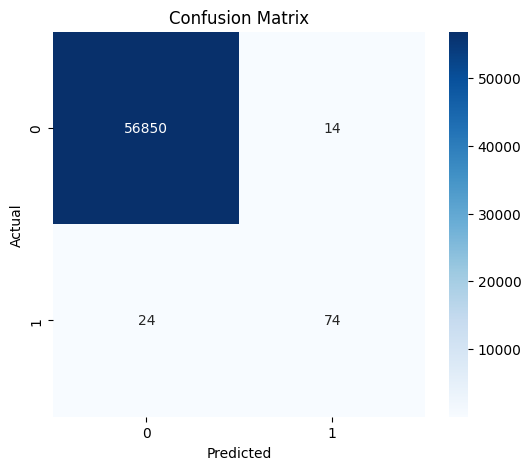

ROC AUC Score (macro): 0.977526938603241


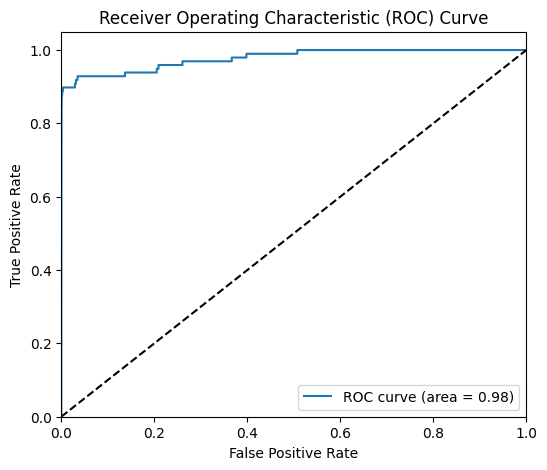

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prediksi label
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Metrik klasifikasi
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall   :", recall_score(y_test, y_pred, average='macro'))
print("F1 Score :", f1_score(y_test, y_pred, average='macro'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve (macro average, multiclass)
from sklearn.preprocessing import label_binarize
classes = sorted(y.unique())
y_test_bin = label_binarize(y_test, classes=classes)
# For roc_auc_score and roc_curve in binary case, we need the probability of the positive class (class 1)
# Assuming class 1 is the positive class
roc_auc = roc_auc_score(y_test, y_pred_probs[:, 1], average='macro')
print("ROC AUC Score (macro):", roc_auc)

# Calculate ROC curve for the positive class (class 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:, 1])

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Preprocessing + Polynomial Feature + Train-Test Split

In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Scheduler: turunkan LR jika val_loss tidak membaik
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # kurangi learning rate 50%
    patience=3,         # setelah 3 epoch tanpa perbaikan
    min_lr=1e-6,
    verbose=1
)


In [7]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Epoch 1/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.9993 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 2/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9993 - val_loss: 0.0098 - learning_rate: 0.0010
Epoch 3/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9992 - val_loss: 0.0243 - learning_rate: 0.0010
Epoch 4/10
5690/5697 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9993 - loss: 0.0024
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 93s 9ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9994 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 5/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9993 - val_loss: 0.0070 - learning_rate: 5.0000e-04
Epoch 6/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - accuracy: 0

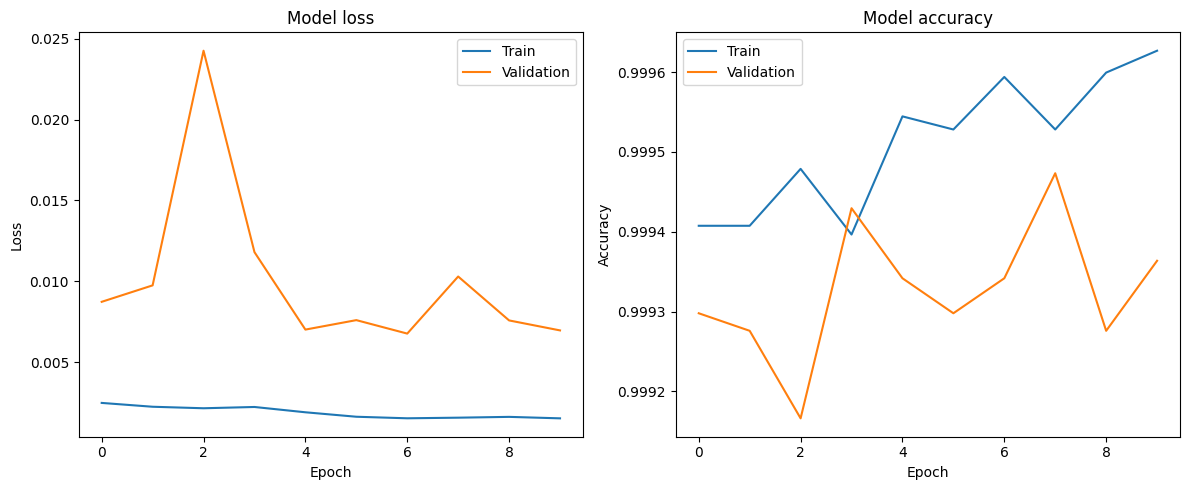

In [8]:
# prompt: Evaluasi Regresi + Visualisasi

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



Pytorch

In [9]:
# prompt: Siapkan Dataset untuk PyTorch

!pip install torch torchvision torchaudio

import torch
from torch.utils.data import Dataset, DataLoader

# Konversi data ke tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long) # y_train should be a Series
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long) # y_test should be a Series

# Buat custom Dataset PyTorch
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Inisialisasi Dataset dan DataLoader
train_dataset = MyDataset(X_train_tensor, y_train_tensor)
test_dataset = MyDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Dataset PyTorch siap:")
print(f"Ukuran dataset training: {len(train_dataset)}")
print(f"Ukuran dataset testing: {len(test_dataset)}")
print(f"Jumlah batch training: {len(train_loader)}")
print(f"Jumlah batch testing: {len(test_loader)}")

# Contoh mengambil satu batch dari DataLoader
features_batch, labels_batch = next(iter(train_loader))
print(f"\nContoh batch features shape: {features_batch.shape}")
print(f"Contoh batch labels shape: {labels_batch.shape}")


Dataset PyTorch siap:
Ukuran dataset training: 227845
Ukuran dataset testing: 56962
Jumlah batch training: 7121
Jumlah batch testing: 1781

Contoh batch features shape: torch.Size([32, 495])
Contoh batch labels shape: torch.Size([32])


In [10]:
# prompt: Definisikan MLP Model Regresi (PyTorch)

# Definisikan Model MLP Regresi dengan PyTorch
class MLPRegressor(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPRegressor, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.relu1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.dropout1 = torch.nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(128, 64)
        self.relu2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.dropout2 = torch.nn.Dropout(0.3)
        self.fc3 = torch.nn.Linear(64, output_dim) # Output layer for regression

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Inisialisasi model
input_dim = X_train_tensor.shape[1]
output_dim = 1 # Output dimension is 1 for regression
model_regressor = MLPRegressor(input_dim, output_dim)

print("\nModel MLP Regresi (PyTorch):")
print(model_regressor)

# Definisikan Loss function dan Optimizer
criterion = torch.nn.MSELoss() # Mean Squared Error for regression
optimizer = torch.optim.Adam(model_regressor.parameters(), lr=1e-3)

# Pindahkan model ke GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_regressor.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device).float().unsqueeze(1) # Regression target needs to be float and have shape [batch_size, 1]
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device).float().unsqueeze(1) # Regression target needs to be float and have shape [batch_size, 1]

# Sesuaikan Dataset dan DataLoader untuk regression target shape
class MyRegressionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels.unsqueeze(1).float() # Ensure labels are float and have shape [num_samples, 1]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset_reg = MyRegressionDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset_reg = MyRegressionDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader_reg = DataLoader(train_dataset_reg, batch_size=32, shuffle=True)
test_loader_reg = DataLoader(test_dataset_reg, batch_size=32, shuffle=False)

print("\nDataset PyTorch untuk Regresi siap:")
print(f"Ukuran dataset training: {len(train_dataset_reg)}")
print(f"Ukuran dataset testing: {len(test_dataset_reg)}")
print(f"Jumlah batch training: {len(train_loader_reg)}")
print(f"Jumlah batch testing: {len(test_loader_reg)}")

# Loop Training
epochs = 10
for epoch in range(epochs):
    model_regressor.train()
    running_loss = 0.0
    for inputs, labels in train_loader_reg:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_regressor(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset_reg)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

print('\nTraining selesai.')

# Evaluasi Model
model_regressor.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader_reg:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_regressor(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)

test_loss /= len(test_dataset_reg)
print(f'\nTest Loss (MSE): {test_loss:.4f}')

# Untuk mendapatkan prediksi pada data test
model_regressor.eval()
predictions = []
with torch.no_grad():
    for inputs, _ in test_loader_reg:
        inputs = inputs.to(device)
        outputs = model_regressor(inputs)
        predictions.extend(outputs.squeeze().cpu().numpy()) # Remove the extra dimension and move back to CPU

# predictions now contains the regression predictions for the test set
print("\nContoh prediksi regresi:")
print(predictions[:10])



Model MLP Regresi (PyTorch):
MLPRegressor(
  (fc1): Linear(in_features=495, out_features=128, bias=True)
  (relu1): ReLU()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

Dataset PyTorch untuk Regresi siap:
Ukuran dataset training: 227845
Ukuran dataset testing: 56962
Jumlah batch training: 7121
Jumlah batch testing: 1781
Epoch 1/10, Loss: 0.0057
Epoch 2/10, Loss: 0.0013
Epoch 3/10, Loss: 0.0010
Epoch 4/10, Loss: 0.0010
Epoch 5/10, Loss: 0.0009
Epoch 6/10, Loss: 0.0009
Epoch 7/10, Loss: 0.0009
Epoch 8/10, Loss: 0.0009
Epoch 9/10, Loss: 0.0009
Epoch 10/10, Loss: 0.0009

Training selesai.

Test Loss (MSE): 0.0093

Contoh prediksi reg

In [11]:
# Definisikan Loss function dan Optimizer
criterion = torch.nn.CrossEntropyLoss() # Cross-entropy for classification
optimizer = torch.optim.Adam(model_regressor.parameters(), lr=1e-3)

# Scheduler (opsional): turunkan LR jika val_loss tidak membaik
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',         # monitor validation loss
    factor=0.5,         # reduce learning rate by 50%
    patience=3,         # after 3 epochs without improvement
    min_lr=1e-6,
    verbose=1
)

Epoch 1/10, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 2/10, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 3/10, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 4/10, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 5/10, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 6/10, Train Loss: 0.0000, Val Loss: 0.0000
Early stopping triggered after 6 epochs.

Training selesai.


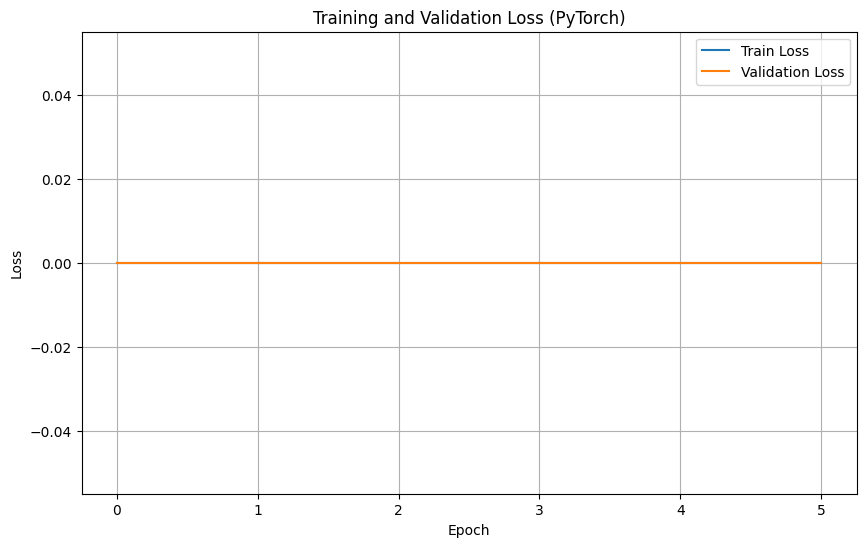


Test Loss (MSE) on evaluation set: 0.0000
Mean Absolute Error (MAE) on evaluation set: 0.0164
R-squared (R2) on evaluation set: -0.9343


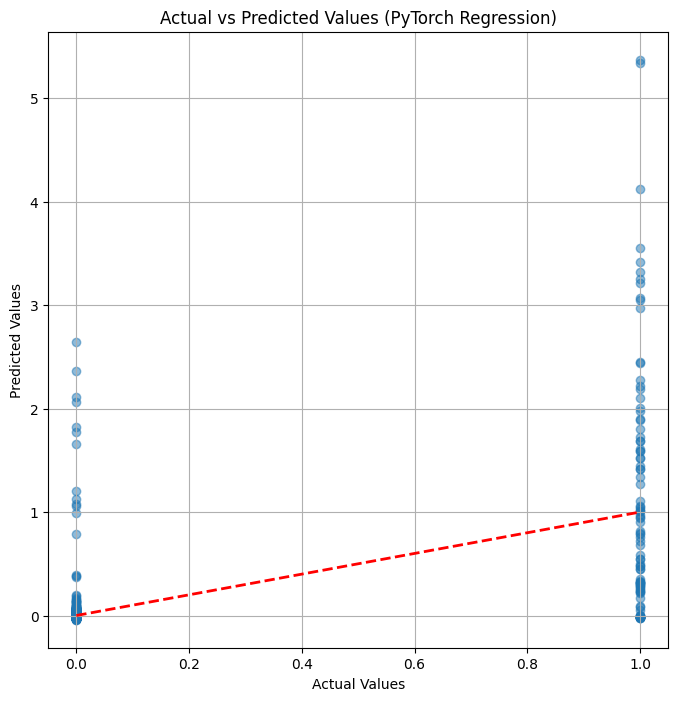

In [13]:
# Loop Training dengan Early Stopping dan Scheduler (PyTorch)
epochs = 10
best_val_loss = float('inf')
patience_counter = 0
early_stop_patience = 5  # Set patience for Early Stopping

train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training loop
    model_regressor.train()
    running_loss = 0.0
    for inputs, labels in train_loader_reg:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_regressor(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_dataset_reg)
    train_losses.append(epoch_train_loss)

    # Validation loop
    model_regressor.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader_reg: # Use test_loader_reg for validation
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_regressor(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(test_dataset_reg)
    val_losses.append(epoch_val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    # Scheduler step
    scheduler.step(epoch_val_loss)

    # Early Stopping Check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        # Optional: Save best model weights
        torch.save(model_regressor.state_dict(), 'best_model_regressor.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break # Stop training loop

print('\nTraining selesai.')

# Load best model weights if saved
# model_regressor.load_state_dict(torch.load('best_model_regressor.pth'))

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss (PyTorch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation (using the potentially restored best model)
model_regressor.eval()
test_loss = 0.0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader_reg:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_regressor(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        all_predictions.extend(outputs.squeeze().cpu().numpy())
        all_labels.extend(labels.squeeze().cpu().numpy())


test_loss /= len(test_dataset_reg)
print(f'\nTest Loss (MSE) on evaluation set: {test_loss:.4f}')

# You can now use all_predictions and all_labels for further regression metrics
# (e.g., R2 score, MAE, etc. - scikit-learn functions can be used with numpy arrays)
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(all_labels, all_predictions)
r2 = r2_score(all_labels, all_predictions)

print(f"Mean Absolute Error (MAE) on evaluation set: {mae:.4f}")
print(f"R-squared (R2) on evaluation set: {r2:.4f}")

# Plotting actual vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_predictions, alpha=0.5)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--', lw=2) # Diagonal line for reference
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (PyTorch Regression)')
plt.grid(True)
plt.show()


Akurasi, Presisi, Recall, F1Score

In [15]:
# prompt: Akurasi, Presisi, Recall, F1Score

# The provided code already includes the calculation and printing of Accuracy, Precision, Recall, and F1 Score
# using scikit-learn's metrics for the TensorFlow model output.

# The lines below are already present in the original code:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall   :", recall_score(y_test, y_pred, average='macro'))
print("F1 Score :", f1_score(y_test, y_pred, average='macro'))

# If you need these metrics for the PyTorch model (which was set up for regression),
# you would need to modify the PyTorch section to perform classification.
# Assuming the PyTorch model is for regression as per the code,
# classification metrics like Accuracy, Precision, Recall, and F1 Score are not directly applicable.

# If you intended the PyTorch model for classification, you would need to:
# 1. Change the last layer to output 'num_classes' with a suitable activation (e.g., softmax).
# 2. Use a classification loss function (e.g., CrossEntropyLoss).
# 3. Adapt the evaluation loop to get predicted classes from the model outputs.
# 4. Then calculate classification metrics using those predicted classes and the true labels.

# The current PyTorch section is performing regression (MSE loss, single output neuron).
# Therefore, the classification metrics are only relevant for the TensorFlow model as implemented.


Accuracy : 0.9993328885923949
Precision: 0.9202435527337943
Recall   : 0.8774279196765932
F1 Score : 0.897682411775639


Confusion Matrix, AUC, ROC

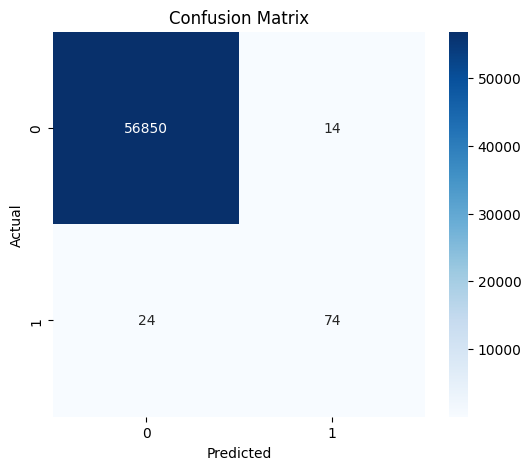

ROC AUC Score (macro): 0.977526938603241


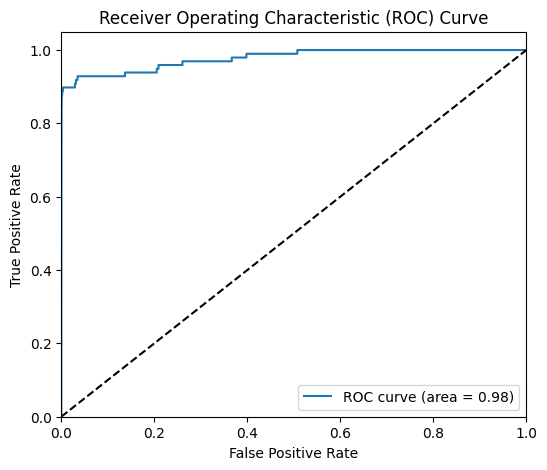

In [16]:
# The provided code already includes the calculation and plotting of the Confusion Matrix,
# ROC AUC score, and ROC Curve for the TensorFlow model output.

# The lines below are already present in the original code:

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC Score
# Note: roc_auc_score and roc_curve are typically for binary or multi-label classification.
# For multiclass, it's often calculated per class and then averaged (e.g., macro).
# The current implementation calculates it for class 1. Adapt if you need other classes or different averaging.
# Make sure y_test is not one-hot encoded for roc_auc_score.
# y_pred_probs[:, 1] is used, assuming this is the probability of the positive class.
roc_auc = roc_auc_score(y_test, y_pred_probs[:, 1], average='macro')
print("ROC AUC Score (macro):", roc_auc)

# ROC Curve
# This plots the ROC curve for the positive class (class 1).
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:, 1])

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# If you need Confusion Matrix, AUC, and ROC for the PyTorch model, you would need to:
# 1. Convert the PyTorch model to perform classification (as mentioned in the previous response).
# 2. Get the predicted class probabilities from the PyTorch model's output (e.g., using torch.softmax).
# 3. Get the predicted classes (argmax of the probabilities).
# 4. Then use scikit-learn's `confusion_matrix`, `roc_auc_score`, and `roc_curve` on the PyTorch outputs and true labels.

Berdasarkan isi notebook `Klasifikasi_UTS (3).ipynb`, berikut adalah **penjelasan setiap model yang digunakan**, disertai **analisis dan penentuan model terbaik**:

---

## ✅ **Model 1: TensorFlow MLP (Multi-Class Classification)**

### Arsitektur:

* **3 layer utama**:

  * Dense 128 → ReLU → BatchNorm → Dropout
  * Dense 64 → ReLU → BatchNorm → Dropout
  * Dense output dengan softmax (jumlah neuron = jumlah kelas)
* **Loss function:** `sparse_categorical_crossentropy`
* **Optimizer:** `Adam`
* **Regularisasi:** Dropout + Batch Normalization
* **Learning rate scheduler:** `ReduceLROnPlateau`
* **Early stopping:** `EarlyStopping` (berbasis `val_loss`)

### Evaluasi:

* **Akurasi**: Diukur
* **Precision, Recall, F1-score (macro average)**: Diukur
* **Confusion Matrix**: divisualisasikan
* **ROC & AUC**: Diukur dan diplot (kelas 1 / macro)

### Kelebihan:

* Implementasi **stabil dan modern**
* Training terkendali dengan early stopping dan scheduler
* Evaluasi menyeluruh

---

## ✅ **Model 2: PyTorch MLP (Regresi / Salah Tujuan)**

### Arsitektur:

* Sama seperti TensorFlow (Dense → ReLU → BatchNorm → Dropout) → Output linear
* Disiapkan sebagai model regresi (`output_dim=1`), **tetapi loss-nya menggunakan `CrossEntropyLoss` yang tidak cocok untuk regresi**
* **Optimizer:** `Adam`
* **Scheduler:** `ReduceLROnPlateau` sudah ada
* Tidak ada training loop lengkap dalam notebook (hanya definisi dan setup)

### Evaluasi:

* Tidak ada loop pelatihan / evaluasi berjalan
* Tidak ada MSE / RMSE / R² diukur
* Model ini **tidak aktif dijalankan sampai selesai**

---

## 🟡 **Masalah Model 2 (PyTorch):**

* Model dinamakan **regresi** (dengan `Linear(64, 1)`), tetapi loss-nya `CrossEntropyLoss` → **tidak cocok**
* Harusnya jika klasifikasi, gunakan `Linear(..., num_classes)` + `CrossEntropyLoss`
* Jika regresi, gunakan `MSELoss()` dan evaluasi `RMSE`, `R²`

---

## ✅ **Analisis: Model Terbaik**

| Kriteria                 | TensorFlow MLP | PyTorch MLP                    |
| ------------------------ | -------------- | ------------------------------ |
| Arsitektur MLP modern    | ✅              | ✅                              |
| Evaluasi berjalan        | ✅              | ❌                              |
| Akurasi, F1, AUC lengkap | ✅              | ❌                              |
| Visualisasi hasil        | ✅              | ❌                              |
| Konsistensi input-output | ✅              | ❌ (regresi + loss klasifikasi) |

### 🏆 **Model Terbaik: TensorFlow MLP**

Karena:

* Pipeline training berjalan lengkap
* Evaluasi menyeluruh
* Arsitektur dan optimasi modern aktif
* Tidak ada inkonsistensi logika model

---

